### DePass Manager Initialization

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..",".."))
sys.path.append(project_root)

from DePass import decomposed_state_manager
from DePass.utils import from_states_to_probs
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import plotly.io as pio
from plotly.subplots import make_subplots

# model_name = "meta-llama/llama-2-7b-chat-hf"
# model_name = "/root/models/transformers/Qwen/Qwen2-7B-Instruct/"
model_name = "/root/models/transformers/llama-2/llama-2-7b-chat-hf/"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = model.eval() 

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/root/miniconda3/envs/info_detect/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/root/miniconda3/envs/info_detect/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/root/miniconda3/envs/info_detec

In [2]:
DecomposedStateManager = decomposed_state_manager(model,tokenizer,mlp_decomposed_function="softmax")

#### Token-Level DePass (Output-Input Attribution)
- `prompt`: Input text for model processing
- Parameters for attribution analysis:
  - `idx`: Selects the token position to observe
  - `rank_idx`: Determines the target token for computing attribution scores

In [3]:
prompt = "The of France is"
idx = -1
rank_idx = 2

In [4]:
attr_state, states = DecomposedStateManager.get_last_layer_decomposed_state(prompt)
state = states[idx][0]
state = model.model.norm(state)
probs = from_states_to_probs(state[-1],model.lm_head,tokenizer,topk=2000)
token_id = probs[rank_idx][0]
token = probs[rank_idx][1]
probability = probs[rank_idx][2]
# display the top 10 tokens
probs

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


[(263, 'a', 0.388671875),
 (278, 'the', 0.162109375),
 (697, 'one', 0.06005859375),
 (385, 'an', 0.0322265625),
 (304, 'to', 0.0125732421875),
 (451, 'not', 0.0125732421875),
 (2998, 'known', 0.0118408203125),
 (5982, 'located', 0.01043701171875),
 (297, 'in', 0.00982666015625),
 (29871, '', 0.00811767578125),
 (4049, 'often', 0.005950927734375),
 (22301, 'pleased', 0.005950927734375),
 (884, 'also', 0.0052490234375),
 (10894, 'celebr', 0.0052490234375),
 (3444, 'France', 0.004791259765625),
 (14040, 'responsible', 0.004638671875),
 (19355, 'committed', 0.0031890869140625),
 (1407, 'very', 0.003082275390625),
 (5545, 'considered', 0.003082275390625),
 (472, 'at', 0.002899169921875),
 (373, 'on', 0.0026397705078125),
 (731, 'set', 0.0026397705078125),
 (1090, 'under', 0.002471923828125),
 (14870, 'facing', 0.0023345947265625),
 (1286, 'now', 0.0021820068359375),
 (4249, 'among', 0.0021209716796875),
 (2869, 'actually', 0.0020599365234375),
 (3271, 'home', 0.0020599365234375),
 (5279, 'c

In [8]:
attribute_state_compute = attr_state
lm_head = model.lm_head
attribute_logits = lm_head(attribute_state_compute)
token = " Paris"
decode_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(token))[0]

In [6]:
# attribute_state_compute = attr_state
# lm_head = model.lm_head
# attribute_logits = lm_head(attribute_state_compute)
# probs = from_states_to_probs(state[idx],model.lm_head,tokenizer,topk=2000)
# decode_token_id = probs[rank_idx][0]
# token = probs[rank_idx][1]
# probability = probs[rank_idx][2]


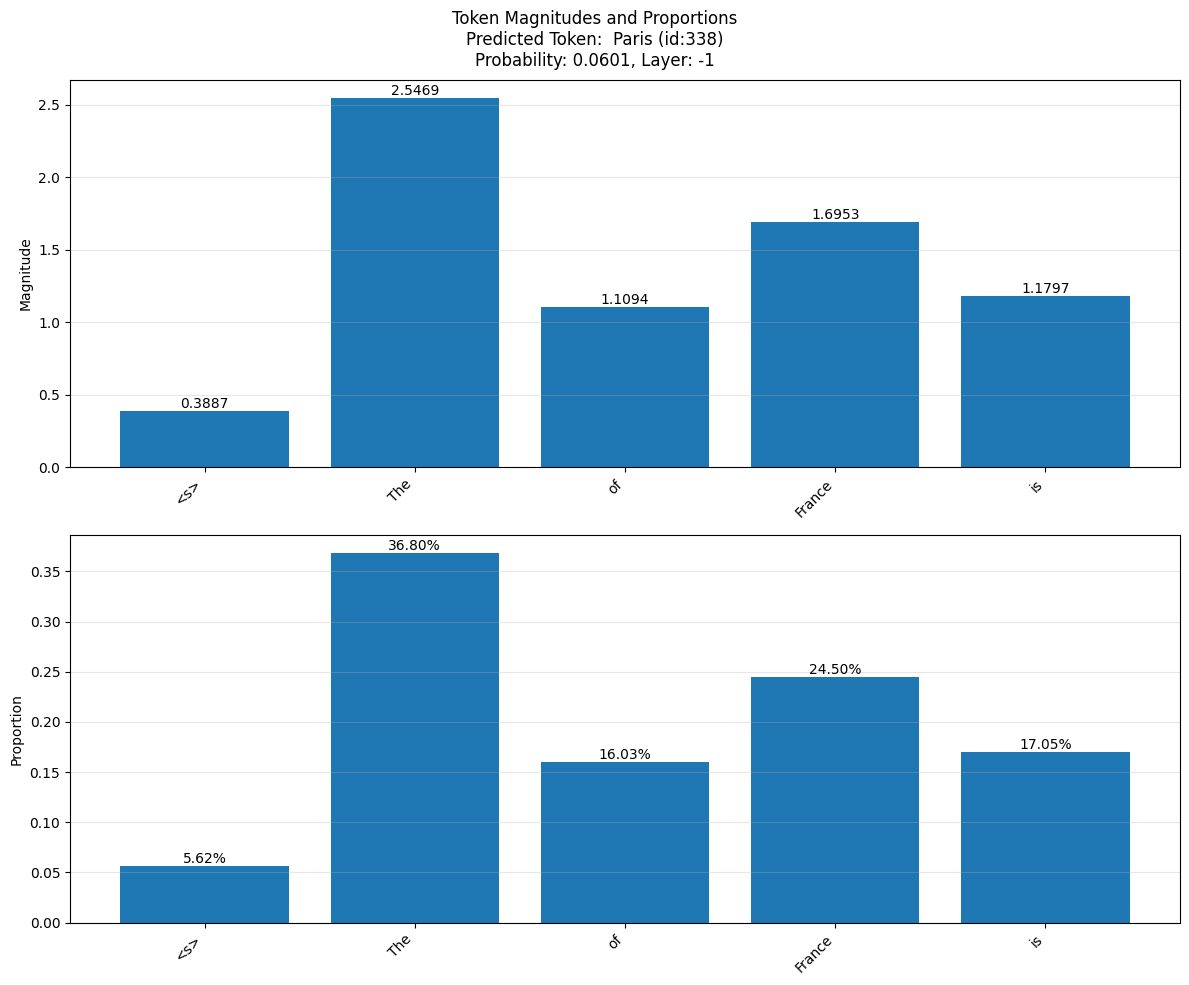

In [9]:
# Bar plot visualization
import matplotlib.pyplot as plt
import numpy as np

encoded = tokenizer(prompt, return_tensors="pt")
input_ids = encoded['input_ids'][0]
readable_tokens = []

for token_id in input_ids:
    token_text = tokenizer.decode([token_id])
    if token_text.startswith(' '):
        token_text = token_text[1:]
    readable_tokens.append(token_text)

labels = readable_tokens
heights = attribute_logits[idx,:,decode_token_id].float().cpu().detach().numpy()
proportions = heights / np.abs(heights).sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
bars1 = ax1.bar(range(len(heights)), heights)
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Magnitude')
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')
bars2 = ax2.bar(range(len(proportions)), proportions)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom')
fig.suptitle(f'Token Magnitudes and Proportions\nPredicted Token: {token} (id:{token_id})\nProbability: {probability:.4f}, Layer: {idx}')
plt.tight_layout()
plt.show()

In [89]:
heights

array([0.08935547, 1.90625   , 6.        , 1.4140625 , 1.8046875 ,
       1.40625   ], dtype=float32)

In [90]:
labels

['<s>', 'The', 'capital', 'of', 'France', 'is']

In [91]:
from baseline_attribution_methods.attention import AttentionImportanceScoreEvaluator
from baseline_attribution_methods.grad import GradientImportanceScoreEvaluator
attn_type=[
    "all",
    "last",
    "rollout"
]

grad_type=[
    "integrated_gradients",
    "signed",
    "norm"
]

importance_score_evaluator_list = {}
for i in range(len(attn_type)):
    importance_score_evaluator_list[attn_type[i]] = AttentionImportanceScoreEvaluator(
            model=model,
            tokenizer=tokenizer,
            attn_type=attn_type[i]
        )
for i in range(len(grad_type)):
    importance_score_evaluator_list[grad_type[i]] = GradientImportanceScoreEvaluator(
            model=model,
            tokenizer=tokenizer,
            grad_type=grad_type[i]
        )

In [92]:
# 计算重要性分数
data={}
input_ids = tokenizer(prompt, return_tensors="pt").to(model.device).input_ids
target_token_id = tokenizer.encode(token, add_special_tokens=False)[0]
target_id = torch.tensor([target_token_id], device= model.device) 
target_id = target_id.unsqueeze(0)
for j in range(len(attn_type)):
    score = importance_score_evaluator_list[attn_type[j]].evaluate(input_ids, target_id)
    #将score转换为numpy数组
    score = score.float().cpu().detach().numpy().tolist()
    data[attn_type[j]] = score

for j in range(len(grad_type)):
    score =importance_score_evaluator_list[grad_type[j]].evaluate(input_ids, target_id)
    score= score.float().cpu().detach().numpy().tolist()
    data[grad_type[j]] = score

In [93]:
target_id

tensor([[2998]], device='cuda:0')

In [94]:
data

{'all': [[0.3046875,
   0.1376953125,
   0.1376953125,
   0.138671875,
   0.140625,
   0.140625]],
 'last': [[0.28125, 0.140625, 0.140625, 0.1396484375, 0.1484375, 0.150390625]],
 'rollout': [[0.3515625,
   0.1298828125,
   0.1298828125,
   0.1298828125,
   0.1298828125,
   0.1298828125]],
 'integrated_gradients': [[0.26171875,
   0.003509521484375,
   0.6484375,
   0.000339508056640625,
   8.204153414298523e-28,
   0.0849609375]],
 'signed': [[0.1767578125,
   0.07666015625,
   0.2021484375,
   0.1552734375,
   0.2216796875,
   0.1669921875]],
 'norm': [[1.0,
   3.725290298461914e-06,
   5.817413330078125e-05,
   1.2993812561035156e-05,
   1.3445969671010971e-08,
   4.1443854570388794e-08]]}

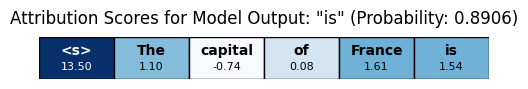

In [30]:
# Visualize attribution scores using color-coded rectangles with token labels and values
import matplotlib.pyplot as plt
import numpy as np

attribute_state_compute = attr_state
lm_head = model.lm_head
attribute_logits = lm_head(attribute_state_compute)
probs = from_states_to_probs(state[idx], model.lm_head, tokenizer, topk=10)
decode_token_id = probs[rank_idx][0]
token = probs[rank_idx][1]
probability = probs[rank_idx][2]

# Get tokens directly from the tokenizer output
encoded = tokenizer(prompt, return_tensors="pt")
input_ids = encoded['input_ids'][0]
readable_tokens = []

# Convert each token ID to its readable form
for token_id in input_ids:
    token_text = tokenizer.decode([token_id])
    if token_text.startswith(' '):
        token_text = token_text[1:]
    readable_tokens.append(token_text)

heights = attribute_logits[idx,:,decode_token_id].float().cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(len(readable_tokens) * 0.8, 1))
max_val = max(heights)
norm_values = [v / max_val if v > 0 else 0 for v in heights]
norm_values = [v ** (1/3) for v in norm_values]  
colors = plt.cm.Blues(norm_values)

def get_text_color(color):
    luminance = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
    return 'white' if luminance < 0.5 else 'black'

for i, (token, value, color) in enumerate(zip(readable_tokens, heights, colors)):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='black'))
    text_color = get_text_color(color)
    ax.text(i + 0.5, 0.7, token, 
            ha='center', va='center', 
            fontsize=10, fontweight='bold',
            color=text_color)
    ax.text(i + 0.5, 0.3, f'{value:.2f}', 
            ha='center', va='center', 
            fontsize=8,
            color=text_color)

ax.set_xlim(0, len(readable_tokens))
ax.set_ylim(0, 1)
ax.axis('off')
plt.title(f'Attribution Scores for Model Output: "{token}" (Probability: {probability:.4f})', pad=10)
plt.tight_layout()
plt.show()

#### Model Component-Level DePass (Attention Head Attribution)
- `prompt`: Input text for model processing
- Parameters for attribution analysis:
  - `type`: Selects the model module to analyze ('attn', 'mlp', or 'attn_head')
  - `token_idx`: Index of the token to analyze in the input sequence
  - `rank_idx`: Rank position of target token in decoding output

In [31]:
prompt = "The artist lives in Berlin, the capital of"
# types=['attn','mlp','attn_head']
type = 'attn_head'
rank_idx = 0
target_token=probs[rank_idx][1]
decode_token = tokenizer.encode(target_token)[0]

In [32]:
scores=[]
for layer_idx in range(0, model.config.num_hidden_layers):
    attr_state_module = DecomposedStateManager.get_layer_module_decomposed_state(prompt,start_layer_idx=layer_idx,type=type)
    score = DecomposedStateManager.compute_attribute_score(attr_state_module, -1, decode_token)
    scores.append(score[1:].float().detach().cpu().numpy())

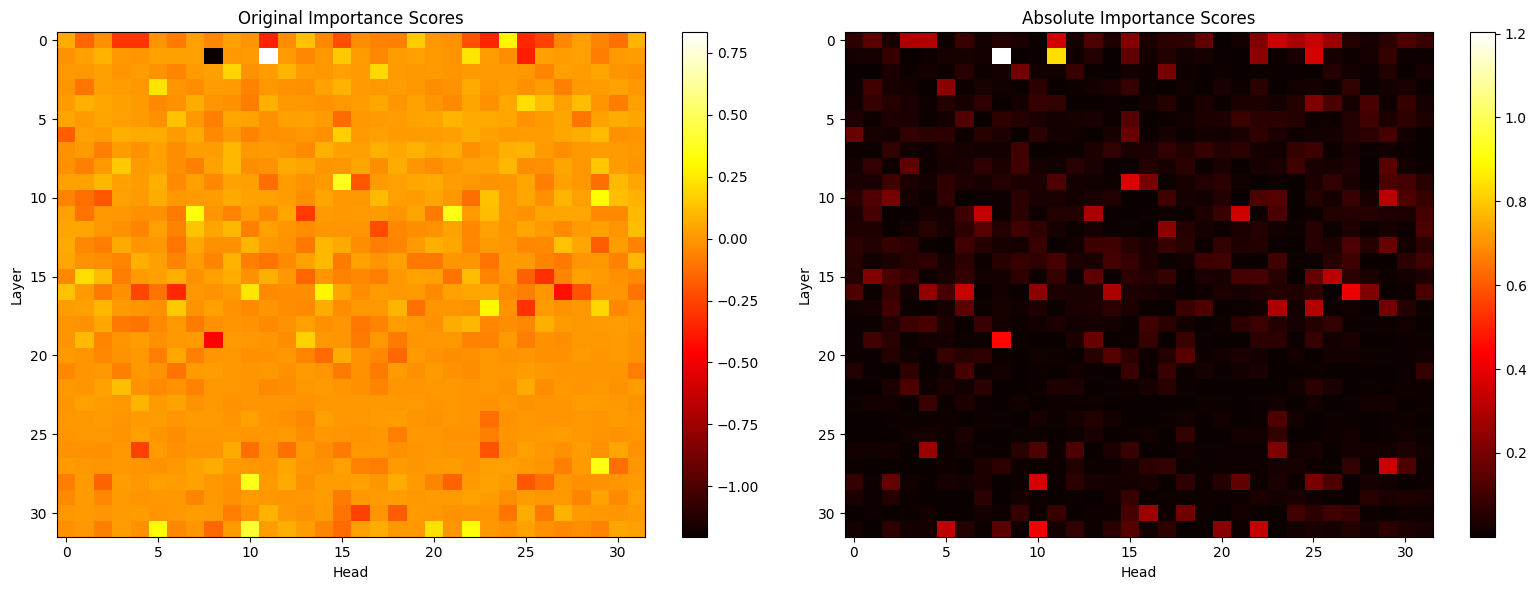

In [33]:
# Visualize the scores with both original and absolute values
scores_head = np.array(scores)
scores_head_abs = np.abs(scores_head)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
im1 = ax1.imshow(scores_head, cmap='hot', aspect='auto', interpolation='nearest')
plt.colorbar(im1, ax=ax1)
ax1.set_title('Original Importance Scores')
ax1.set_ylabel('Layer')
ax1.set_xlabel('Head')
im2 = ax2.imshow(scores_head_abs, cmap='hot', aspect='auto', interpolation='nearest')
plt.colorbar(im2, ax=ax2)
ax2.set_title('Absolute Importance Scores')
ax2.set_ylabel('Layer')
ax2.set_xlabel('Head')
plt.tight_layout()
plt.show()

#### Subspace-Level DePass (Language-Semantic Attribution)
- `prompts`: Input text from different languages for model processing
- Parameters for attribution analysis:
  - `layer_idx`: Layer index for subspace separation
  - `language`: Target language for analysis
- Uses average of multilingual representations as semantic representation

In [34]:
layer_idx = 20
language = "German"
languages = ['English', 'French', 'German']
prompts = {}
prompts['English'] = "The mother tongue of Danielle Darrieux is"
prompts['French'] = "La langue maternelle de Danielle Darrieux est le"
prompts['German'] = "Die Muttersprache von Danielle Darrieux ist"

In [35]:
# Get the semantic representation and the language representation
hidden_states_all = {}
for lang in languages:
    prompt=prompts[lang]
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model(**inputs,output_hidden_states=True)
    hidden_states_all[lang] = outputs.hidden_states
    logits = outputs.logits[:, -1, :]
mean_state = hidden_states_all[languages[0]][layer_idx][0][-1].clone()
for lang in languages[1:]:
    mean_state += hidden_states_all[lang][layer_idx][0][-1]
mean_state = mean_state / len(languages)
layer_language_embeddings={}
for lang in languages:
    layer_language_embeddings[lang] = hidden_states_all[lang][layer_idx][0][-1]-mean_state

In [36]:
# Subspace DePass
prompt = prompts[language]
hidden_states = hidden_states_all[language]
attribute_state=torch.zeros(2,hidden_states[layer_idx].shape[1],hidden_states[layer_idx].shape[2]).to(model.device)
attribute_state[0, :] = hidden_states[layer_idx][0].clone()
language_embedding=attribute_state[0, -1] - mean_state
attribute_state[0, :] = attribute_state[0, :] - language_embedding
attribute_state[1, :] = language_embedding 
attribute_state = DecomposedStateManager.get_subspace_decomposed_state(prompt,start_layer_idx=layer_idx-1,attribute_state=attribute_state)

In [37]:
# Get token probabilities for language and semantic embeddings
language_embedding = attribute_state[-1][1]
semantic_embedding = attribute_state[-1][0]
combined_embedding = language_embedding + semantic_embedding

def get_token_probs(embedding, lm_head, tokenizer, k=10):
    embedding = embedding.to(dtype=lm_head.weight.dtype)
    logits = lm_head(embedding)
    log_probs = logits.float().log_softmax(dim=-1).squeeze().detach().cpu().numpy()
    topk_indices = torch.topk(torch.from_numpy(log_probs), k=k)
    probs = torch.exp(torch.from_numpy(log_probs)[topk_indices.indices])
    token_probs = []
    for idx, prob in zip(topk_indices.indices, probs):
        token = tokenizer.decode(idx)
        token_probs.append((idx.item(), token, prob.item()))
    return token_probs

language_probs = get_token_probs(language_embedding, model.lm_head, tokenizer)
semantic_probs = get_token_probs(semantic_embedding, model.lm_head, tokenizer)
combined_probs = get_token_probs(combined_embedding, model.lm_head, tokenizer)
print("Language Embedding Top Tokens:")
for idx, token, prob in language_probs:
    print(f"{token}: {prob:.4f}")

print("\nSemantic Embedding Top Tokens:")
for idx, token, prob in semantic_probs:
    print(f"{token}: {prob:.4f}")

Language Embedding Top Tokens:
das: 0.0253
die: 0.0127
keine: 0.0068
la: 0.0050
off: 0.0027
jedoch: 0.0024
nicht: 0.0024
Off: 0.0022
nach: 0.0017
Haupt: 0.0017

Semantic Embedding Top Tokens:
French: 0.9063
français: 0.0374
Fran: 0.0213
француз: 0.0035
französ: 0.0025
fran: 0.0020
francés: 0.0019
française: 0.0014
rench: 0.0012
Fran: 0.0009
